In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### I. Data - first look

In [2]:
train = pd.read_csv('data/drugsComTrain_raw.tsv', sep='\t', index_col=0).reset_index(drop=True)
test = pd.read_csv('data/drugsComTest_raw.tsv', sep='\t', index_col=0).reset_index(drop=True)

In [3]:
train.head()

,drugName,condition,review,rating,date,usefulCount
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [4]:
train.shape

(161297, 6)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   drugName     161297 non-null  object 
 1   condition    160398 non-null  object 
 2   review       161297 non-null  object 
 3   rating       161297 non-null  float64
 4   date         161297 non-null  object 
 5   usefulCount  161297 non-null  int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 7.4+ MB


In [6]:
train.describe()

,rating,usefulCount
count,161297.000000,161297.000000
mean,6.994377,28.004755
std,3.272329,36.403742
min,1.000000,0.000000
25%,5.000000,6.000000
50%,8.000000,16.000000
75%,10.000000,36.000000
max,10.000000,1291.000000


In [7]:
print('There are {} features over {} samples in the dataset;'.format(train.shape[1], train.shape[0]))
print('{} drugs for {} conditions;'.format(len(train['drugName'].unique()), len(train['condition'].unique())))
print('{} reviews and {} ratings averaging {:0.2f};'.format(train.shape[0], train.shape[0], np.mean(train['rating'])))
print('{0:.0f} average usefull counts'.format(np.mean(train['usefulCount'])))

There are 6 features over 161297 samples in the dataset;
3436 drugs for 885 conditions;
161297 reviews and 161297 ratings averaging 6.99;
28 average usefull counts


### II. Setting tasks and considerations

Because there isn't a task already defined, I need to come up with an idea I want to explore. For this specific dataset, there are a few things I can do:

1. Cluster the drugs based on reviews and conditions.
2. Name entity extraction and matching for drugs.
3. Build a model to predict the ratings for drugs base on the reviews

There are following considerations in choosing ML techniques and strategies:
* Time: all of the tasks above does not need real time or near real time inference, which allows for more complicated models.
* Resource: unknown.
* Explanabiltiy: can be important for task 1 and , but less so for 2.
* 3 would probably need 2 for aspect sentiment modelling.

Since all of the tasks involve analysing the review text, I start with that.

### III. Feature engineering and EDA on reviews

In [8]:
import spacy

#### III.a A quick look at the reviews to have a feel of what's in them.

In [9]:
for i in range(5):
    print(train.loc[i, 'review'])
    print(train.loc[i+50000, 'review'])
    print(train.loc[i+100000, 'review'])

"It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil"
"I was skeptical about suboxone when I first heard about it, thinking it was just getting high off of one drug to replace another, but I was wrong.  Suboxone is actually working well to help get my life back in order.  It keeps me from having bad detox, controls my cravings, and also has some sedating, and sometimes annoying side effects, it does not flat out get me high like I originally thought it would.  Suboxone really is a serious treatment for opioid addiction and I strongly recomend it"
"This medicine is terrible. In fact doctors are terrible for prescribing it. Thanks to a 15 min session of my psychiatrist nodding (while barely looking at me) then writing down a name of a pill to &quot;fix me&quot; my face has never seen such acne. He thought I was depressed before, now I don&#039;t want to even leave the house. DOCTORS OVER PRESCRIBE!!!!! Please trust me, go to your herbal neighborhood store and ge

There are the following observations and thoughts:
1. `&#039;` (') and `&quot;` (") didn't get encoded properly that needs cleaning.
2. "" around reviews need stripping
3. Sentiment is multi-dimensional that calls for more targeted sentiment analysis instead of blanket analysis
4. Entity recognition of related medicines can be useful to build knowledge.

#### III.b Data cleaning and tokenisation

In [10]:
import html
train['review'] = train['review'].apply(html.unescape)
train['review'] = train['review'].str.strip('"')

In [11]:
# check result
for i in range(5):
    print(train.loc[i+100, 'review'])
    print(train.loc[i+50300, 'review'])
    print(train.loc[i+106000, 'review'])

Awful medicine, the worst. The side effects outweigh the benefit.  Headache the first night, leg and back pain, Sensitive skin,  just awful. Pain got worse and worse. I changed my meds to ciproflaxcin. I have used this in the past so hopefully, it will continue to help. I even questioned the doc at urgent care to see if I can take cipro and she offered macrobid. Maybe this urgent care and this medication is something they get a deal on....stay away from macrobid.
I'm 27 and I have been using Drysol since I was 21.  I found deodorants and antiperspirants did not work for me.  I have never been a heavy sweater but when I would wear them the combination of my sweat and the products would be a weird soapy smell.  I used Drysol at first once a week (using it 2 nights in a row gave me an armpit rash which hurt) but I used it when I needed *if I smelled and was sweating I would use it again that night*  I find the next night after using it my armpits are a little itchy, but I have nothing to 

Looks clean! Now tokenisation with the new spaCy! The new model is roberta-base

In [12]:
nlp = spacy.load('en_core_web_trf')

In [13]:
# tokenize and lemmatize
def tokenise(text):
    doc = nlp(text)
    return [word.lemma_ for word in doc]

# entity name extraction
def ne(text):
    doc = nlp(text)
    return [ent.text for ent in doc.ents if ent.label_=='PRODUCT']

In [14]:
train['review'][:1].apply(tokenise)

0    [it, have, no, side, effect, ,, I, take, it, i...
Name: review, dtype: object

In [15]:
train['review'][1:3].apply(ne)

1           [Intuniv]
2    [Lybrel, Lybrel]
Name: review, dtype: object

In [16]:
print(train.loc[0, 'review'])

It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil


In [17]:
doc = nlp(train.loc[0, 'review'])
print([ent.text for ent in doc.ents])

[]


In [18]:
train.loc[[1, 2], 'drugName']

1    Guanfacine
2        Lybrel
Name: drugName, dtype: object

A quick test above explosed the kind of problem with the entity matching. SpaCy's entity recognition recognises 'Intuniv' is a name of the drug, but 'Guanfacine' recorded in the 'drugName' column is actually the active ingredient. The second can be matched well. In light of this, I update my plans as follows:

1. For clustering, instead looking at building a network graph?
2. For name entity matching: it could be interesting to look at how entities map in relation to each other, drug names, active ingredients, related drugs mentioned, and conditions using a network graph?
3. For rating prediction: the entity names needs to be macthed and replaced before aspect sentiment analysis. To avoid problems stemming from competitor/alternative drug mentions or ambigorous drug names mismatching. There are following solutions: a) Drug/ingredients matching --> use a dictionary of drug|ingredients matches to help matching review mentions to 'drugName'. b) Failing to match drug names --> assume general sentiment is the aspect sentiment towards this drug.
4. Update the maching network graph with aspects and sentiments

In [23]:
from preprocessing import *

In [28]:
%%time
train['review_lemma'] = preprocess(train['review'], lemma_chunk, chunksize=1000)

CPU times: user 3.81 s, sys: 1.71 s, total: 5.52 s
Wall time: 6h 6min 50s


In [33]:
%%time
train['review_ent'] = preprocess(train['review'], ent_chunk, chunksize=1000)

KeyboardInterrupt: 

In [31]:
train

,drugName,condition,review,rating,date,usefulCount,review_lemma
0,Valsartan,Left Ventricular Dysfunction,"It has no side effect, I take it in combinatio...",9.0,"May 20, 2012",27,"[it, have, no, side, effect, ,, I, take, it, i..."
1,Guanfacine,ADHD,My son is halfway through his fourth week of I...,8.0,"April 27, 2010",192,"[my, son, be, halfway, through, his, fourth, w..."
2,Lybrel,Birth Control,"I used to take another oral contraceptive, whi...",5.0,"December 14, 2009",17,"[I, use, to, take, another, oral, contraceptiv..."
3,Ortho Evra,Birth Control,This is my first time using any form of birth ...,8.0,"November 3, 2015",10,"[this, be, my, first, time, use, any, form, of..."
4,Buprenorphine / naloxone,Opiate Dependence,Suboxone has completely turned my life around....,9.0,"November 27, 2016",37,"[Suboxone, have, completely, turn, my, life, a..."
...,...,...,...,...,...,...,...
161292,Campral,Alcohol Dependence,I wrote my first report in Mid-October of 2014...,10.0,"May 31, 2015",125,"[I, write, my, first, report, in, Mid, -, Octo..."
161293,Metoclopramide,Nausea/Vomiting,I was given this in IV before surgey. I immedi...,1.0,"November 1, 2011",34,"[I, be, give, this, in, iv, before, surgey, .,..."
161294,Orencia,Rheumatoid Arthritis,"Limited improvement after 4 months, developed ...",2.0,"March 15, 2014",35,"[limit, improvement, after, 4, month, ,, devel..."
161295,Thyroid desiccated,Underactive Thyroid,"I've been on thyroid medication 49 years, I sp...",10.0,"September 19, 2015",79,"[I, 've, be, on, thyroid, medication, 49, year..."


In [35]:
train.to_csv('data/train.csv', index=False)

In [ ]:
train_sm = train[:2000]

In [47]:
%%time
train_sm['review_ent'] = train_sm['review'].apply(ne)

CPU times: user 11min 42s, sys: 9.41 s, total: 11min 51s
Wall time: 11min 47s


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [48]:
train_sm['review_ent'] = train_sm['review_ent'].apply(set)

<ipython-input-48-194c6300c383>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_sm['review_ent'] = train_sm['review_ent'].apply(set)


In [52]:
train_sm.head(20)

,drugName,condition,review,rating,date,usefulCount,review_lemma,review_ent
0,Valsartan,Left Ventricular Dysfunction,"It has no side effect, I take it in combinatio...",9.0,"May 20, 2012",27,"[it, have, no, side, effect, ,, I, take, it, i...",{}
1,Guanfacine,ADHD,My son is halfway through his fourth week of I...,8.0,"April 27, 2010",192,"[my, son, be, halfway, through, his, fourth, w...",{Intuniv}
2,Lybrel,Birth Control,"I used to take another oral contraceptive, whi...",5.0,"December 14, 2009",17,"[I, use, to, take, another, oral, contraceptiv...",{Lybrel}
3,Ortho Evra,Birth Control,This is my first time using any form of birth ...,8.0,"November 3, 2015",10,"[this, be, my, first, time, use, any, form, of...",{}
4,Buprenorphine / naloxone,Opiate Dependence,Suboxone has completely turned my life around....,9.0,"November 27, 2016",37,"[Suboxone, have, completely, turn, my, life, a...",{oxycontin}
5,Cialis,Benign Prostatic Hyperplasia,2nd day on 5mg started to work with rock hard ...,2.0,"November 28, 2015",43,"[2nd, day, on, 5, mg, start, to, work, with, r...",{5}
6,Levonorgestrel,Emergency Contraception,"He pulled out, but he cummed a bit in me. I to...",1.0,"March 7, 2017",5,"[he, pull, out, ,, but, he, cumme, a, bit, in,...",{}
7,Aripiprazole,Bipolar Disorde,Abilify changed my life. There is hope. I was ...,10.0,"March 14, 2015",32,"[Abilify, change, my, life, ., there, be, hope...","{Clonidine, 5, Clondine, Zoloft, Abilify}"
8,Keppra,Epilepsy,I Ve had nothing but problems with the Keppe...,1.0,"August 9, 2016",11,"[ , I, ve, have, , nothing, but, problem, wit...",{Keppera}
9,Ethinyl estradiol / levonorgestrel,Birth Control,I had been on the pill for many years. When my...,8.0,"December 8, 2016",1,"[I, have, be, on, the, pill, for, many, year, ...",{}


### III. Entity matching

Immediately, there are a few problems with the entity extracted:
1. Numbers were extracted wrongly. --> remove numbers using regex
2. Misspelling --> fuzzy match (?)
3. Non-drug products mentioned --> consider keeping them for network visualisation
4. Some drug names have not been extracted --> ??


In [82]:
# remove numbers
train_sm['review_ent'] = train_sm['review_ent'].apply(lambda x: [name for name in x if not name.replace('.','',1).isdigit()])

<ipython-input-82-47ec2a22340c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_sm['review_ent'] = train_sm['review_ent'].apply(lambda x: [name for name in x if not name.replace('.','',1).isdigit()])


In [83]:
train_sm.to_csv('data/train_sm.csv')

### IV. Network analysis

Visualise in network graph [reference](https://towardsdatascience.com/tutorial-network-visualization-basics-with-networkx-and-plotly-and-a-little-nlp-57c9bbb55bb9)

In [87]:
graph_df = train_sm[['drugName', 'condition', 'review_ent']]
graph_df['review_ent'].apply(len).max()

10

In [90]:
range(10)

range(0, 10)

In [92]:
graph_df[list(range(10))] = pd.DataFrame(graph_df['review_ent'].tolist(), index=graph_df.index)

/Users/luluo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [100]:
graph_df.drop('review_ent', axis=1, inplace=True)

In [105]:
import networkx as nx

In [128]:
# focus on top 10 conditions
vis_df = graph_df[graph_df['condition'].isin(graph_df['condition'].value_counts().index[:10])]

In [125]:
G = nx.from_pandas_edgelist(vis_df,
                            source='condition',
                            target='drugName',
                            edge_attr=None,
                            create_using=nx.Graph()
                           )

In [126]:
# pos = nx.layout.fruchterman_reingold_layout(G, k=1, iterations=1000, scale=2)

In [130]:
from pyvis.network import Network
g = Network(height=800, width=800, notebook=True)
g.barnes_hut()
g.from_nx(G)
g.show('nx.html')

There are some interesting observations:
* Mental health and contraception seems to be the main conditions.
* There are some drugs overlaps between birth control and acne, depression|anxiety|insomnia and pain.
* More worryingly ADHD have some overlaps with depression!

Obviously the graph can be improved, but time is limited.

Would be good to add some product names mentioned in review names too

### V. Sentiment analysis

Some EDA on two datasets.

<AxesSubplot:xlabel='rating', ylabel='Count'>

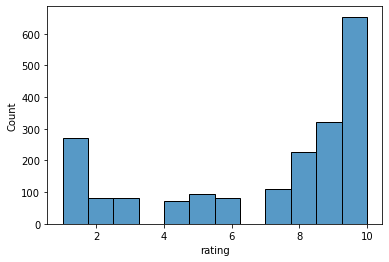

In [56]:
sns.histplot(train_sm['rating'])

<AxesSubplot:xlabel='rating', ylabel='Count'>

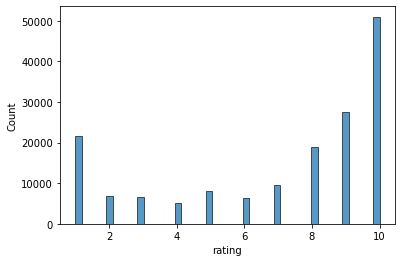

In [57]:
sns.histplot(train['rating'])

The small sample seems to follow the same distribution as the original, but there is imblance and maybe some sampling methods should be used.

In [60]:
print('train_sm contains {} drugs'.format(len(train_sm['drugName'].unique())))
print('train contrains {} drugs'.format(len(train['drugName'].unique())))

train_sm contains 717 drugs
train contrains 3436 drugs


In [62]:
print('train_sm contains {} conditions'.format(len(train_sm['condition'].unique())))
print('train contrains {} conditions'.format(len(train['condition'].unique())))

train_sm contains 265 conditions
train contrains 885 conditions


#### V.a Traditional NLP
* Feature engineering: review text length, all capital words
* TF-IDF or FastText (better for misspelled words)
* RF as baseline
* For aspect sentiment modelling, add aspect words (using topic modelling?) and study dependencies
* Explore data augmentation to increase minority sample size

#### V.b Neural NLP

General sentiment prediction

Because of mispelling and strong sentiment indication from capital words, I choose RoBERTa. I provide some code snipets, but no time for training.

In [132]:
import transformers
from transformers import RobertaForSequenceClassification, RobertaTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch.utils.data import TensorDataset

In [134]:
class BertEncoder():
    def __init__(self, input_data, tokenizer):
        self.tokenizer = tokenizer
        self.input_data = input_data
    
    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        return self.input_data[idx]
    
    def tokenize(self, max_len):
        encoded_dicts = []
        for text in self.input_data:
            encoded_dict = self.tokenizer(
                text = text,
                add_special_tokens=True,
                padding='max_length',
                truncation=True,
                max_length=max_len,
                return_attention_mask=True,
                return_tensors='pt'
            )
            encoded_dicts.append(encoded_dict)
        input_ids = torch.cat([encoded_dict['input_ids'] for encoded_dict in encoded_dicts], dim=0)
        attention_masks = torch.cat([encoded_dict['attention_mask'] for encoded_dict in encoded_dicts], dim=0)

        return input_ids, attention_masks

In [53]:
MODEL_NAME = 'roberta-base'
texts = train['review'].tolist()
labels = train['ratings'].apply(lambda x: int(x))

train_dataset = BertEncoder(
    tokenizer=RobertaTokenizer.from_pretrained('roberta-base'), 
    input_data=train_texts

train_data = train_dataset.tokenize(max_len=510)
test_data = test_dataset.tokenize(max_len=510)

train_input_ids, train_attention_masks = train_data
test_input_ids, test_attention_masks = test_data

train_labels = torch.Tensor(train_labels.to_list()).long()
test_labels = torch.Tensor(test_labels.to_list()).long()

train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

model = RobertaForSequenceClassification.from_pretrained(
    'roberta-base',
    output_attentions=False,
    output_hidden_states=False,
    num_labels = 10
)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=8,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=10,
    weight_decay=0.01,
    logging_dir='./logs',
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    data_collator=dummy_data_collector
)

trainer.train()
trainer.save_model('./model')
trainer.evaluate()


Aspect sentiment modelling

Try [ABSA](https://pypi.org/project/aspect-based-sentiment-analysis/)

Need to first design an aspect list (side effect, effectiveness, effective time, etc.)

Would be cool to update the network graph with aspect sentiment.